In [14]:
%matplotlib inline
from scipy import misc
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage

# Introduction to SIFT (Scale-Invariant Feature Transform)

---
## 参考资料

[Introduction to SIFT (Scale-Invariant Feature Transform)](https://docs.opencv.org/3.3.0/da/df5/tutorial_py_sift_intro.html)

In [23]:
# ndimage.imread?
# misc.imresize?

Signature: misc.imresize(*args, **kwds)
Docstring:
`imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


    Resize an image.

    This function is only available if Python Imaging Library (PIL) is installed.

    .. warning::

        This function uses `bytescale` under the hood to rescale images to use
        the full (0, 255) range if ``mode`` is one of ``None, 'L', 'P', 'l'``.
        It will also cast data for 2-D images to ``uint32`` for ``mode=None``
        (which is the default).

    Parameters
    ----------
    arr : ndarray
        The array of image to be resized.
    size : int, float or tuple
        * int   - Percentage of current size.
        * float - Fraction of current size.
        * tuple - Size of the output image (height, width).

    interp : str, optional
        Interpolation to use for re-sizing ('nearest', 'lanczos', 'bilinear',
        'bicubic' or 'cubic').
    mode

In [24]:
img = misc.imread('../../data/lena.jpg', flatten=True)

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  """Entry point for launching an IPython kernel.


In [25]:
img.shape

(512, 512)

In [26]:
img.dtype

dtype('float32')

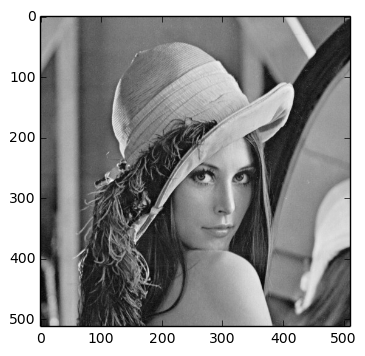

In [28]:
plt.imshow(img, cmap='gray')

In [44]:
# SIFT参数
s = 3 # 高斯图像数量为s+3
k = 2 ** (1.0 / s)
sigma = 1.6
pyr_num = s+3

In [45]:
# 高斯滤波每一层标准差
kvec1 = np.array([1.3, sigma, sigma * k, sigma * (k ** 2), sigma * (k ** 3), sigma * (k ** 4)])
kvec2 = np.array([sigma * (k ** 2), sigma * (k ** 3), sigma * (k ** 4), sigma * (k ** 5), sigma * (k ** 6), sigma * (k ** 7)])
kvec3 = np.array([sigma * (k ** 5), sigma * (k ** 6), sigma * (k ** 7), sigma * (k ** 8), sigma * (k ** 9), sigma * (k ** 10)])
kvec4 = np.array([sigma * (k ** 8), sigma * (k ** 9), sigma * (k ** 10), sigma * (k ** 11), sigma * (k ** 12), sigma * (k ** 13)])
kvectotal = np.array([sigma, sigma * k, sigma * (k ** 2), sigma * (k ** 3), sigma * (k ** 4), sigma * (k ** 5), sigma * (k ** 6), sigma * (k ** 7), sigma * (k ** 8), sigma * (k ** 9), sigma * (k ** 10), sigma * (k ** 11)])

In [40]:
# 下采样图像，包括2，1，0.5，0.25
img_doubled = misc.imresize(img, 200, 'bilinear').astype(int)
# img_doubled.shape # (1024, 1024)
img_normal = misc.imresize(img_doubled, 50, 'bilinear').astype(int)
# img_normal.shape # (512, 512)
img_halved = misc.imresize(img_normal, 50, 'bilinear').astype(int)
# img_halved.shape # (256, 256)
img_quartered = misc.imresize(img_halved, 50, 'bilinear').astype(int)
# img_quartered.shape # (128, 128)

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  """
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimag

In [43]:
# 初始化高斯图像金字塔image pyramid
pyrlvl1 = np.zeros((img_doubled.shape[0], img_doubled.shape[1], pyr_num))
pyrlvl2 = np.zeros((img_normal.shape[0], img_normal.shape[1], pyr_num))
pyrlvl3 = np.zeros((img_halved.shape[0], img_halved.shape[1], pyr_num))
pyrlvl4 = np.zeros((img_quartered.shape[0], img_quartered.shape[1], pyr_num))